# TEST DATALOADER 2D DISCRETE

In [35]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

In [36]:
xr = xarray.open_dataset("/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc")
xr = xr.rio.write_crs("epsg:4326")

In [37]:
d1 = xr["time"][0]
d2 = xr["time"][10]

In [38]:
d2.values

np.datetime64('1958-09-10T00:00:00.000000000')

In [39]:
xr_xr = xr.sel(time=slice(d1, d2))

In [40]:
xr_xr.to_array().shape

(10, 11, 9, 12)

In [41]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn

class DiscreteDataset(Dataset):
    """Precipitations-TemperatureMin-TemperatureMax dataset."""

    def __init__(self, dict_files, transform=None):
        """
        Args:
            dict_files (string): Path to the .nc file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dict_files = dict_files
        self.timesteps = self.dict_files["timesteps"]

        self.loading_weather()

        self.loading_rasterized_wtd()

        self.transform = transform

    def loading_weather(self):
        self.weather_xr = xarray.open_dataset(self.dict_files["weather_nc_path"])
        self.weather_xr = self.weather_xr.rio.write_crs("epsg:4326")

    def loading_rasterized_wtd(self):
        wtd_df = pd.read_csv(self.dict_files["wtd_csv_path"], dtype= {"sensor_id": "str"})
        wtd_df = wtd_df.astype({"date":'datetime64[ns]'})

        wtd_names  = gpd.read_file(self.dict_files["wtd_shp"], engine='fiona')
        wtd_names = wtd_names.to_crs('epsg:4326')

        dtm_roi = rioxarray.open_rasterio(self.dict_files["dtm_nc"], engine='fiona')
        dtm_roi = dtm_roi.rio.write_crs("epsg:4326")

        all_dates = wtd_df["date"].unique()
        sensor_id_list = wtd_df["sensor_id"].unique()
        
        # add coordinates to wtd values
        sensor_coord_x_list = []
        sensor_coord_y_list = []
        for sensor in sensor_id_list:
            coord_x = wtd_names.loc[wtd_names["sensor_id"] == sensor].geometry.x.values[0]
            coord_y = wtd_names.loc[wtd_names["sensor_id"] == sensor].geometry.y.values[0]
            sensor_coord_x_list.append(coord_x)
            sensor_coord_y_list.append(coord_y)

        from_id_to_coord_x_dict = {sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
        from_id_to_coord_y_dict = {sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

        queries = list(wtd_df["sensor_id"].values)
        coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
        coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

        wtd_df["x"] = coordinates_x
        wtd_df["y"] = coordinates_y

        # downscaling dtm
        downscale_factor = 0.1
        new_width = int(dtm_roi.rio.width * downscale_factor)
        new_height = int(dtm_roi.rio.height * downscale_factor)

        self.dtm_roi_downsampled = dtm_roi.rio.reproject(
            dtm_roi.rio.crs,
            shape=(new_height, new_width),
            resampling=Resampling.bilinear,
        )

        wtd_data_geop = gpd.GeoDataFrame(
        wtd_df, geometry=gpd.points_from_xy(wtd_df["x"], 
                                            wtd_df["y"]), crs="EPSG:4326")
        wtd_data_geop = wtd_data_geop[["date","wtd","geometry"]]
        
        rasterized_ds_list = []
        for date_idx in range(len(all_dates)):
            
            vector_ds = wtd_data_geop.loc[wtd_data_geop["date"] == all_dates[date_idx],:]

            rasterized_ds = make_geocube(vector_data=vector_ds,
                                        measurements=['wtd'],
                                        output_crs="epsg:4326",
                                        resolution=(self.dtm_roi_downsampled.rio.transform().a, self.dtm_roi_downsampled.rio.transform().e))
            
            rasterized_ds_list.append(rasterized_ds)

        self.wtd_data_raserized = xarray.concat(rasterized_ds_list, dim = "time")
        self.wtd_data_raserized = self.wtd_data_raserized.assign_coords({"time": all_dates})

    def __len__(self):
        return len(self.wtd_data_raserized["wtd"]) - self.timesteps
    
    def __getitem__(self, idx):
        """"
        Input: (wtd_t, weather_t-T,t)
        Output: (wtd_t+1:t+T+1)        
        """
        if idx < 0:
            idx = self.__len__() + idx

        input_wtd = self.wtd_data_raserized["wtd"][idx].to_numpy()
        input_wtd_mask = np.ones_like(input_wtd) - np.isnan(input_wtd)
        input_wtd = np.stack((input_wtd, input_wtd_mask), axis=-1)

        d1 = self.wtd_data_raserized["time"][idx+1]
        d2 = self.wtd_data_raserized["time"][idx+self.timesteps]
        input_weather = self.weather_xr.sel(time=slice(d1, d2)).to_array().values

        output_wtd = self.wtd_data_raserized["wtd"][idx+1:idx+1+self.timesteps].to_numpy()
        output_wtd_mask = np.ones_like(output_wtd) - np.isnan(output_wtd)
        output_wtd = np.stack((output_wtd, output_wtd_mask), axis=-1)

        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(input_wtd), torch.from_numpy(input_weather), torch.from_numpy(output_wtd)

In [42]:
dict_files = {
    "wtd_csv_path" : "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv",
    "weather_nc_path" : "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc",
    "wtd_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp",
    "piedmont_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp",
    "dtm_nc" : "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc",
    "timesteps" : 90
}

ds = DiscreteDataset(dict_files)

In [43]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 10137


In [44]:
print(f"Item -1: {ds[-1]}")

Item -1: (tensor([[[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        ...,

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]]], dtype=torch.float64), tensor([[[[ 5.7007e-02,  4.9011e-02,  3.4973e-02,  ...,  5.0049e-03,
            1.0010e-02,  2.6978e-02],
          [ 3.1006e-02,  1.7029

In [45]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([82, 71, 2]) - torch.Size([10, 90, 9, 12]) - torch.Size([90, 82, 71, 2])


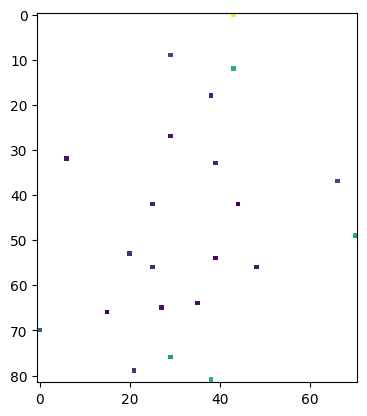

In [46]:
plt.imshow(x[:,:,0])

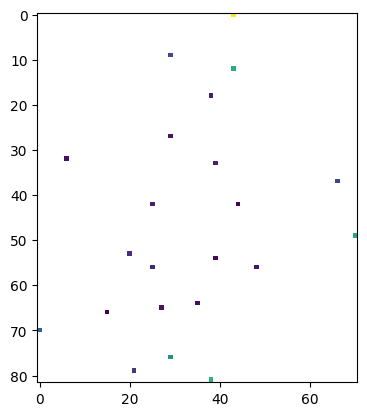

In [ ]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

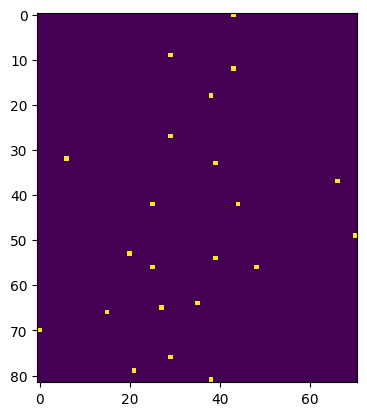

In [70]:
plt.imshow(x[:,:,0] == ds.wtd_data_raserized["wtd"][-91])

In [48]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_2421148/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([40.7867, 10.5067, 26.3783,  5.6700,  4.0600,  4.0000,  5.6723, 10.6167,
         5.2200,  2.4100, 25.4000,  7.3213,  0.0000,  6.3600,  4.2433,  3.5700,
         4.1033,  2.0300,  0.0000, 22.5753,  8.1195,  0.0000],
       dtype=torch.float64)

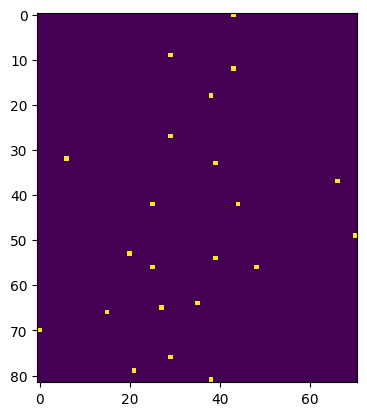

In [49]:
plt.imshow(x[:,:,1])

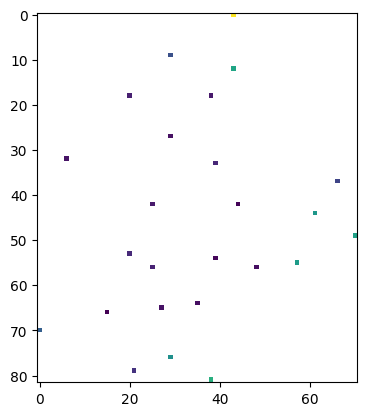

In [50]:
plt.imshow(z[-1,:,:,0])

In [51]:
ds.wtd_data_raserized["wtd"].shape

(10227, 82, 71)

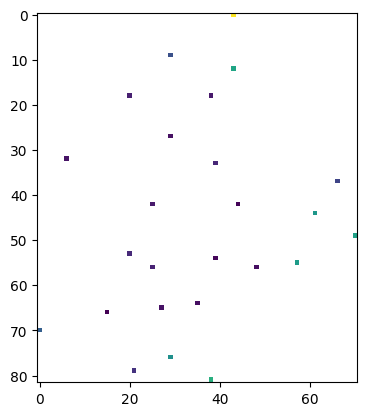

In [52]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

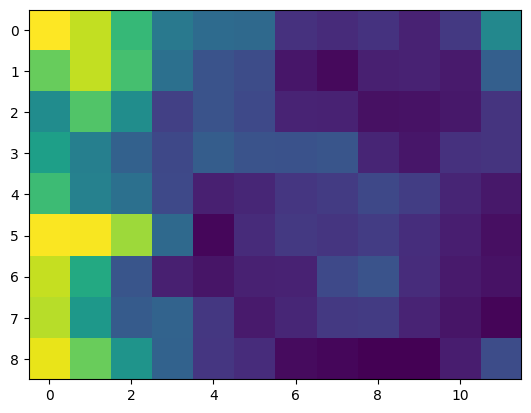

In [76]:
plt.imshow(ds.weather_xr["prec"][-1])

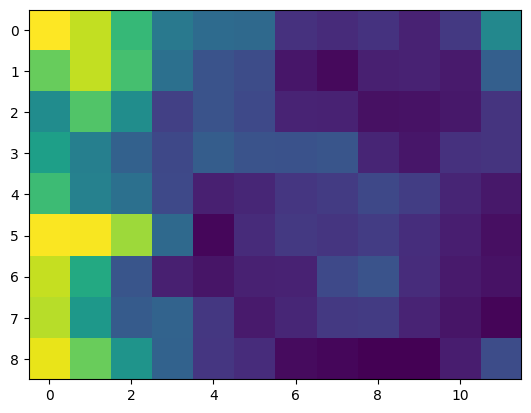

In [78]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [53]:
from torch.utils.data.sampler import SubsetRandomSampler

In [54]:
batch_size = 1000
max_epochs = 1

test_split_p = 0.2
train_split_p = 1 - test_split_p
train_idx = int(ds.__len__()*train_split_p)
test_idx = int(ds.__len__()*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

In [55]:
train_idxs

array([   0,    1,    2, ..., 8106, 8107, 8108])

In [56]:
test_idxs

array([ 8109,  8110,  8111, ..., 10133, 10134, 10135])

In [57]:
input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

In [58]:
from tqdm import tqdm

X = None
Y = None

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                X = np.copy(init_wtd)
                apply_mask(init_wtd)
                Y = init_wtd
                print(init_wtd[0,:,:,1])
                print(X[0,:,:,1])
                break

Epoch 0:   0%|          | 0/9 [00:30<?, ?batch/s]/scratch_local/ipykernel_2421148/2594378935.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
/scratch_local/ipykernel_2421148/2594378935.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m
Epoch 0:   0%|          | 0/9 [00:30<?, ?batch/s]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


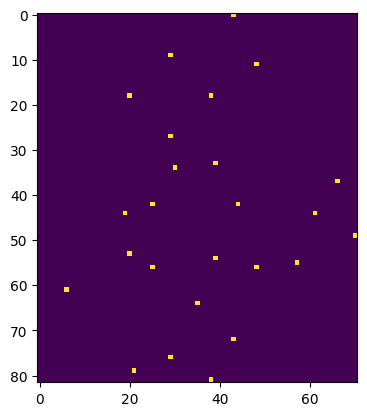

In [59]:
plt.imshow(X[0,:,:,1])

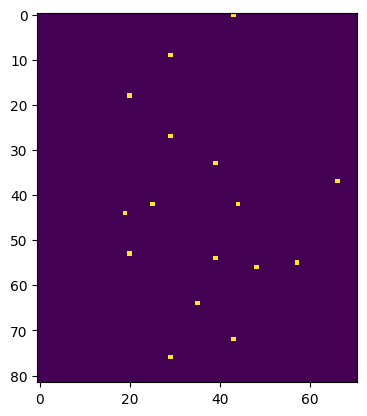

In [60]:
plt.imshow(Y[0,:,:,1])

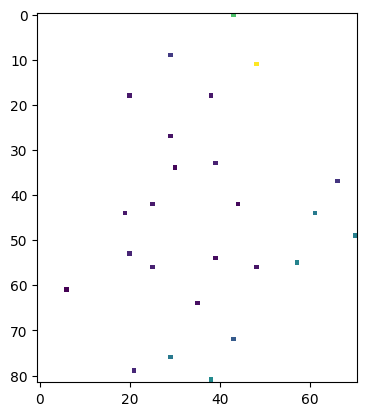

In [61]:
plt.imshow(X[0,:,:,0])

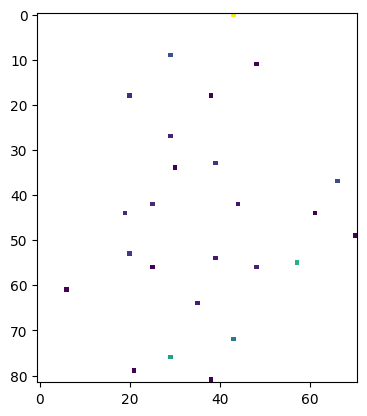

In [62]:
plt.imshow(Y[0,:,:,0])